In [1]:
#Necessary Imports for Data Cleaning and Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
pd.set_option('display.max_rows', None)

In [3]:
job_df = pd.read_csv('cleaned_fake_job_postings.csv')
job_df.shape

(17880, 74)

In [5]:
num_fake_jobs = job_df['fraudulent'].sum()
num_fake_jobs

866

In [7]:
#Industry Column
from sklearn.preprocessing import OneHotEncoder

# Initialize the encoder with drop='first' to remove the reference category
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'Standardized_Industry' column
encoded_array = encoder.fit_transform(job_df[['Standardized_Industry']])

# Convert the array into a DataFrame with named columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Standardized_Industry']))

# Concatenate the original DataFrame with the encoded DataFrame
job_df = pd.concat([job_df, encoded_df], axis=1)

# Optionally, drop the original categorical column
job_df.drop(columns=['Standardized_Industry'], inplace=True)


In [9]:
#Department Column

# Fit and transform the 'Standardized_Industry' column
encoded_array = encoder.fit_transform(job_df[['Standardized_Department']])

# Convert the array into a DataFrame with named columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Standardized_Department']))

# Concatenate the original DataFrame with the encoded DataFrame
job_df = pd.concat([job_df, encoded_df], axis=1)

# Optionally, drop the original categorical column
job_df.drop(columns=['Standardized_Department'], inplace=True)

In [11]:
job_df = job_df.loc[:, ~job_df.columns.duplicated()]

In [13]:
#Balancing the data
import pandas as pd
from sklearn.utils import resample

# Split data
fake_jobs = job_df[job_df['fraudulent'] == 1]  # Minority class (fake)
real_jobs = job_df[job_df['fraudulent'] == 0]  # Majority class (real)

# Define sampling strategy (e.g., real jobs = 2x fake jobs)
undersample_real = real_jobs.sample(n=2 * len(fake_jobs), random_state=42)  # Undersample real jobs
oversample_fake = resample(fake_jobs, replace=True, n_samples=len(undersample_real), random_state=42)  # Oversample fake jobs

# Combine into balanced dataset
balanced_df = pd.concat([undersample_real, oversample_fake])

# Verify balance
print(balanced_df['fraudulent'].value_counts())

fraudulent
0    1732
1    1732
Name: count, dtype: int64


In [15]:
balanced_df.shape

(3464, 72)

In [17]:
# Get all column names
print("All attributes/columns in balanced_df:")
print(balanced_df.columns.tolist())

All attributes/columns in balanced_df:
['job_id', 'title', 'location', 'department', 'Standardized_Department_Administrative', 'Standardized_Department_Business Consulting', 'Standardized_Department_Creative & Design', 'Standardized_Department_Customer Service', 'Standardized_Department_Education & Training', 'Standardized_Department_Engineering', 'Standardized_Department_Finance & Accounting', 'Standardized_Department_Government & Public Sector', 'Standardized_Department_Healthcare', 'Standardized_Department_Hospitality & Food Services', 'Standardized_Department_Human Resources', 'Standardized_Department_IT', 'Standardized_Department_Legal & Compliance', 'Standardized_Department_Logistics & Supply Chain', 'Standardized_Department_Manufacturing & Production', 'Standardized_Department_Marketing', 'Standardized_Department_Media & Communications', 'Standardized_Department_Not Provided', 'Standardized_Department_Operations', 'Standardized_Department_Product Management & Development', 'Stan

In [19]:
balanced_df.to_csv('balanced_df.csv', index=False)

In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import combinations

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Load your DataFrame (assuming it's already created as balanced_df)
# balanced_df = pd.read_csv('your_file.csv')

# Separate numerical and categorical columns
numerical_cols = balanced_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = [col for col in balanced_df.columns if col not in numerical_cols]

# --- Numerical vs. Numerical (Pearson Correlation) ---
num_num_correlations = balanced_df[numerical_cols].corr(method='pearson')

# print("\nNumerical vs. Numerical Correlation (Pearson):\n", num_num_correlations)

# Identify highly correlated pairs (absolute value > 0.7)
high_num_num_corr = {}
for i, col in enumerate(numerical_cols):
    for j in range(i+1, len(numerical_cols)):
        col2 = numerical_cols[j]
        corr_val = num_num_correlations.loc[col, col2]
        if abs(corr_val) > 0.7:
            high_num_num_corr[(col, col2)] = corr_val

# print("\nHighly Correlated Numerical Pairs (Pearson > 0.7):\n", high_num_num_corr)

# --- Categorical vs. Categorical (Cramer's V) ---
cat_cat_correlations = {}
for col1, col2 in combinations(categorical_cols, 2):
    cat_cat_correlations[(col1, col2)] = cramers_v(balanced_df[col1], balanced_df[col2])

# print("\nCategorical vs. Categorical Correlation (Cramer's V):\n", cat_cat_correlations)

# Identify highly correlated pairs (Cramer's V > 0.7)
high_cat_cat_corr = {k: v for k, v in cat_cat_correlations.items() if v > 0.7}

# print("\nHighly Correlated Categorical Pairs (Cramer's V > 0.7):\n", high_cat_cat_corr)

# --- Numerical vs. Categorical ---

#For numerical vs categorical correlation, additional analysis is needed such as ANOVA or point-biserial correlation


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming your DataFrame is already loaded as balanced_df

# Identify Standardized Industry columns for dropping
industry_cols = [col for col in balanced_df.columns if col.startswith('Standardized_Industry')]

# Separate features (X) and target (y)
X = balanced_df.drop(['fraudulent', 'job_id'] + industry_cols, axis=1, errors='ignore')
y = balanced_df['fraudulent']

# Select only numeric features for PCA
X_numeric = X.select_dtypes(include=np.number)

# Handle missing values by filling with the mean
X_numeric = X_numeric.fillna(X_numeric.mean())

# Store the original attribute names before scaling
attribute_names = list(X_numeric.columns)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(data=X_pca, index=X_numeric.index, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Reset indices to ensure they're unique before concatenation
pca_df = pca_df.reset_index(drop=True)
y = y.reset_index(drop=True)

# Concatenate PCA components with target variable
final_df = pd.concat([pca_df, y], axis=1)

# Calculate correlation between PCA components and target variable
correlations = final_df.corr()['fraudulent'].sort_values(ascending=False)

# Get loadings (correlation between original variables and PCs)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create DataFrame to show attribute names with loadings for each PC
loadings_df = pd.DataFrame(loadings,
                         index=attribute_names,
                         columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Ensure the index is unique
if not loadings_df.index.is_unique:
    loadings_df = loadings_df[~loadings_df.index.duplicated(keep='first')]

# Get the top 45 components
top_45_components = correlations[1:35].index.tolist()

# Find attributes with highest average absolute loading across top 45 components
avg_abs_loadings = loadings_df[top_45_components].abs().mean(axis=1)

# Get top 45 attributes
top_45_attributes = avg_abs_loadings.nlargest(45).index.tolist()

# Print the top 45 attributes
print("Top 34 attributes to consider for model training (excluding job_id and Standardized Industry):\n", top_45_attributes)

Top 34 attributes to consider for model training (excluding job_id and Standardized Industry):
 ['Standardized_Department_Project Management', 'Standardized_Department_Hospitality & Food Services', 'Standardized_Department_Product Management & Development', 'Standardized_Department_Government & Public Sector', 'Standardized_Department_Human Resources', 'Standardized_Department_Operations', 'Standardized_Department_Logistics & Supply Chain', 'Standardized_Department_Administrative', 'Standardized_Department_Education & Training', 'Standardized_Department_Customer Service', 'Standardized_Department_Research & Development', 'Standardized_Department_Retail & Consumer', 'Standardized_Department_Finance & Accounting', 'Standardized_Department_Healthcare', 'Standardized_Department_Quality Assurance & Testing', 'Standardized_Department_IT', 'Standardized_Department_Engineering', 'Standardized_Department_Technology', 'Standardized_Department_Creative & Design', 'Standardized_Department_Legal & 

In [25]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

top_45_attributes = [
    'Standardized_Department_Project Management',
    'Standardized_Department_Hospitality & Food Services', 
    'Standardized_Department_Product Management & Development', 
    'Standardized_Department_Government & Public Sector', 
    'Standardized_Department_Human Resources',
    'Standardized_Department_Operations', 
    'Standardized_Department_Logistics & Supply Chain', 
    'Standardized_Department_Administrative',
    'Standardized_Department_Education & Training', 
    'Standardized_Department_Customer Service',
    'Standardized_Department_Research & Development',
    'Standardized_Department_Retail & Consumer',
    'Standardized_Department_Finance & Accounting',
    'Standardized_Department_Healthcare',
    'Standardized_Department_Quality Assurance & Testing',
    'Standardized_Department_IT',
    'Standardized_Department_Engineering',
    'Standardized_Department_Technology',
    'Standardized_Department_Creative & Design', 
    'Standardized_Department_Legal & Compliance', 
    'Standardized_Department_Marketing',
    'Standardized_Department_Media & Communications',
    'Standardized_Department_Business Consulting',
    'employment_encoded',
    'salary_diff',
    'Standardized_Department_Manufacturing & Production', 
    'has_questions', 'has_company_logo',
    'telecommuting', 'job_desc_length',
    'education_encoded', 
    'Standardized_Department_Sales', 
    'experience_encoded', 
    'Standardized_Department_Not Provided'

]

filtered_df = balanced_df[top_45_attributes + ['fraudulent']]

# Split into train, validation, and test sets (70/15/15 split)
train_df, temp_df = train_test_split(filtered_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Separate features and target for each set
X_train = train_df.drop('fraudulent', axis=1)
y_train = train_df['fraudulent']

X_val = val_df.drop('fraudulent', axis=1)
y_val = val_df['fraudulent']

X_test = test_df.drop('fraudulent', axis=1)
y_test = test_df['fraudulent']

# Impute missing values (using mean strategy)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Initialize XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    # You can add other hyperparameters here
    # n_estimators=100,
    # max_depth=3,
    # learning_rate=0.1
)

# Train the model
xgb_model.fit(X_train_imputed, y_train)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_imputed)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Evaluate on test set (final evaluation)
y_test_pred = xgb_model.predict(X_test_imputed)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Feature importance
importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

joblib.dump(xgb_model, 'xgb_fraud_model.pkl')
print("Model saved as xgb_fraud_model.pkl")

Validation Accuracy: 0.8923

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       265
           1       0.85      0.94      0.90       255

    accuracy                           0.89       520
   macro avg       0.90      0.89      0.89       520
weighted avg       0.90      0.89      0.89       520


Test Accuracy: 0.8808

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       283
           1       0.85      0.89      0.87       237

    accuracy                           0.88       520
   macro avg       0.88      0.88      0.88       520
weighted avg       0.88      0.88      0.88       520


Top 10 Most Important Features:
                                              Feature  Importance
27                                   has_company_logo    0.339899
16                Standardized_Department_Engineering    0.079817


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:37:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[224  41]
 [ 15 240]]


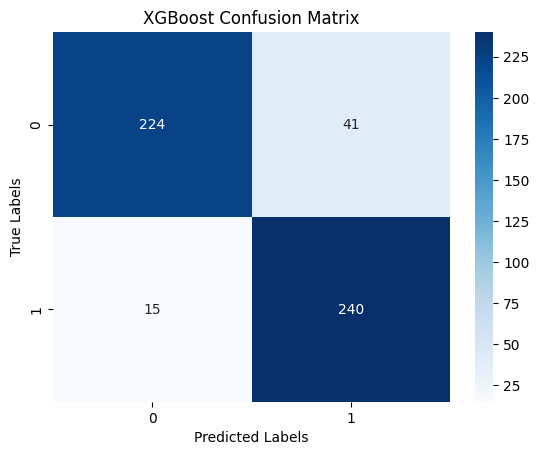

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_imputed)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost Confusion Matrix')
plt.show()


In [ ]:
job_df = pd.read_csv('cleaned_fake_job_postings.csv')
job_df.shape

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_imputed)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost Confusion Matrix')
plt.show()
